In [136]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import plotly.express as px
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D


# Torch
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset

#Sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

Settings

In [288]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### Loading dataset

In [289]:
ds_original = pd.read_csv('..\..\data\external\dataset_phishing.csv', header=0, delimiter=',',decimal=',')

print("Original dataset dimensions:", ds_original.shape)

Original dataset dimensions: (11430, 89)


In [290]:
# L' objectiu és predir si una url és de phishing o no, per tant la variable dependent serà STATUS.
y = ds_original[:]["status"] 
x = ds_original.drop(columns = "status")

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

x

Number of samples: 11430
Number of features: 88


url  length_url  \
0                  http://www.crestonwood.com/router.php          37   
1      http://shadetreetechnology.com/V4/validation/a...          77   
2      https://support-appleld.com.secureupdate.duila...         126   
3                                     http://rgipt.ac.in          18   
4      http://www.iracing.com/tracks/gateway-motorspo...          55   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter          45   
11426  http://www.budgetbots.com/server.php/Server%20...          84   
11427  https://www.facebook.com/Interactive-Televisio...         105   
11428             http://www.mypublicdomainpictures.com/          38   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...         477   

       length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  \
0                   19   0        3           0      0      0       0      0   
1                   23   1        1           0      0      0       0      0   
2                   50   1        4           1      0      1       2      0   
3                   11   0        2           0      0      0       0      0   
4                   15   0        2           2      0      0       0      0   
...                ...  ..      ...         ...    ...    ...     ...    ...   
11425               17   0        2           0      0      0       0      0   
11426               18   0        5           0      1      1       0      0   
11427               16   1        2           6      0      1       0      0   
11428               30   0        2           0      0      0       0      0   
11429               14   1       24           0      1      1       9      0   

       nb_eq  nb_underscore  nb_tilde  nb_percent  nb_slash  nb_star  \
0          0              0         0           0         3        0   
1          0              0         0           0         5        0   
2          3              2         0           0         5        0   
3          0              0         0           0         2        0   
4          0              0         0           0         5        0   
...      ...            ...       ...         ...       ...      ...   
11425      0              0         0           0         4        0   
11426      1              0         0           1         5        0   
11427      1              1         0           0         5        0   
11428      0              0         0           0         3        0   
11429      9             18         0          23         4        0   

       nb_colon  nb_comma  nb_semicolumn  nb_dollar  nb_space  nb_www  nb_com  \
0             1         0              0          0         0       1       0   
1             1         0              0          0         0       0       0   
2             1         0              0          0         0       0       1   
3             1         0              0          0         0       0       0   
4             1         0              0          0         0       1       0   
...         ...       ...            ...        ...       ...     ...     ...   
11425         1         0              0          0         0       1       0   
11426         1         0              0          0         1       1       1   
11427         1         0              0          0         0       1       0   
11428         1         0              0          0         0       1       0   
11429         1         0              9          0         0       1       0   

       nb_dslash  http_in_path  https_token     ratio_digits_url  \
0              0             0            1                  0.0   
1              0             0            1  0.22077922100000005   
2              0             0            0          0.150793651   
3              0             0            1                  0.0   
4              0             0            1      

## Data preprocessing

### - Data cleaning

Searching for empty or unknown values in the dataset

In [291]:
print("Null values:", x.isnull().sum().sum())
print("NA values:", x.isna().sum().sum())

print("\nColumns with values equal to -1:\n", ((x == -1).sum())[((x == -1).sum() != 0).tolist()])


Null values: 0
NA values: 0

Columns with values equal to -1:
 domain_registration_length      46
domain_age                    1781
dtype: int64


Replacing unknown values with the mean of the known values

In [292]:
known_domain_age = x.loc[x['domain_age'] != -1, 'domain_age']
mean_domain_age = known_domain_age.sum()/len(known_domain_age)
mean_domain_age

x.loc[x["domain_age"] == -1, 'domain_age'] = mean_domain_age

known_domain_registration_length = x.loc[x['domain_registration_length'] != -1, 'domain_registration_length']
mean_domain_registration_length = known_domain_registration_length.sum()/len(known_domain_registration_length)
mean_domain_registration_length

x.loc[x["domain_registration_length"] == -1, 'domain_registration_length'] = mean_domain_registration_length

In [293]:
(x[["domain_age", "domain_registration_length"]] == -1).sum()

domain_age                    0
domain_registration_length    0
dtype: int64

The "url" feature is not useful since all the information that can be extracted from it is already collected in the rest of columns.

In [294]:
x = x.drop(columns = "url")

### - Data conversion

Incialment a $Y$ teniem les etiques de "phishing" i "legitimate". Per poder fer regressió ens interessa convertir-les en un valor binari on 1 indica _Phishing_ i 0 no.
També veïem que les mostres estan repartides al 50% entre les dues categoríes (Com s'indica a la descripció de Kaggle).

In [295]:
print(y.describe())

status_labels = y.copy()
y = y.replace({"phishing" : 1, "legitimate" : 0})

print("\nContingut de Y:", set(y))

print("\nDimensionalitat de X:", x.shape)

count          11430
unique             2
top       legitimate
freq            5715
Name: status, dtype: object

Contingut de Y: {0, 1}

Dimensionalitat de X: (11430, 87)


Les columnes de $X$ que tenen nombres decimals apareixen amb un tipus de dada desconegut anomenat _object_. Aixó pot crear problemes més endavant, per tant es bona idea fer una conversió a tipus _float_.

In [296]:
type_of_cols = [x.dtypes == object][0]
for col in range(x.shape[1]):
    if type_of_cols[col]:
        x[x.columns[col]] = x[x.columns[col]].astype('float')

Now $X$ contain just numeric values.

### - Data normalization

First we have to determine which features are categorical.

In [297]:
categorical_features = ["http_in_path", "https_token", "punycode", "port", "tld_in_path", "tld_in_subdomain", "abnormal_subdomain", "prefix_suffix", "random_domain", "shortening_service", "path_extension",
"domain_in_brand", "brand_in_subdomain", "brand_in_path", "suspecious_tld", "login_form", "external_favicon", "submit_email", "sfh", "iframe", "popup_window", "onmouseover", 
"right_clic", "empty_title", "domain_in_title", "domain_with_copyright", "whois_registered_domain", "dns_record", "google_index"]

non_categorical_features = [i for i in x.columns if (i not in categorical_features)]

In [273]:
x_non_categorical = x.drop(columns = categorical_features)
x_categorical = x[categorical_features]

In [274]:
# TODO: solo estandarizar variables no categoricas. No tiene sentido estandarizar las categoricas porque no se conseguira nunca una distribucion normal(por lo tanto no tiene sentido)

scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

x_non_categorical_standard = scaler.fit_transform(x_non_categorical)

array([[-0.43632748, -0.19396372, -0.42102044, ...,  0.        ,
        -0.42934032,  0.32097385],
       [ 0.28706655,  0.17720743,  2.37518157, ...,  0.37123344,
        -0.42934032, -0.46740717],
       [ 1.17322424,  2.6826127 ,  2.37518157, ..., -0.3145125 ,
         2.49161198, -1.25578819],
       ...,
       [ 0.79344237, -0.47234208,  2.37518157, ...,  1.44011028,
        -0.42933631,  2.68611691],
       [-0.41824263,  0.82675695, -0.42102044, ..., -0.76882406,
         0.8011633 ,  0.32097385],
       [ 7.52100688, -0.65792766,  2.37518157, ...,  0.        ,
        -0.42934032, -1.25578819]])

In [305]:
pd.DataFrame(x_non_categorical_standard, non_categorical_features)

ValueError: Shape of passed values is (11430, 58), indices imply (58, 58)

## Feature selection

A good idea for discarding some columns would be to drop those whose mean is or is very close to 0. We can do this only with the features that represent some kind of counter because that means that most of the samples doesn't register that feature.

In [166]:
columns_to_drop = []

for col in range(x.shape[1]):
    name_of_feature = x.columns[col]
    if np.mean(x[name_of_feature]) <= 0.01:
        columns_to_drop.append(name_of_feature)
        
x[columns_to_drop].describe()

nb_or  nb_tilde   nb_star  nb_comma  nb_dollar  nb_dslash  punycode  \
count 11430.000 11430.000 11430.000 11430.000  11430.000  11430.000 11430.000   
mean      0.000     0.007     0.001     0.004      0.002      0.007     0.000   
std       0.000     0.081     0.026     0.103      0.077      0.081     0.019   
min       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
25%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
50%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
75%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
max       0.000     1.000     1.000     4.000      6.000      1.000     1.000   

           port  path_extension  nb_external_redirection  brand_in_subdomain  \
count 11430.000       11430.000                11430.000           11430.000   
mean      0.002           0.000                    0.003               0.004   
std       0.049           0.013                    0.056               0.064   
min       0.000           0.000                    0.000               0.000   
25%       0.000           0.000                    0.000               0.000   
50%       0.000           0.000                    0.000               0.000   
75%       0.000           0.000                    0.000               0.000   
max       1.000           1.000                    1.000               1.000   

       brand_in_path  ratio_nullHyperlinks  ratio_intRedirection  \
count      11430.000             11430.000             11430.000   
mean           0.005                 0.000                 0.000   
std            0.070                 0.000                 0.000   
min            0.000                 0.000                 0.000   
25%            0.000                 0.000                 0.000   
50%            0.000                 0.000                 0.000   
75%            0.000                 0.000                 0.000   
max            1.000                 0.000                 0.000   

       ratio_intErrors  submit_email       sfh    iframe  popup_window  \
count        11430.000     11430.000 11430.000 11430.000     11430.000   
mean             0.000         0.000     0.000     0.001         0.006   
std              0.000         0.000     0.000     0.036         0.077   
min              0.000         0.000     0.000     0.000         0.000   
25%              0.000         0.000     0.000     0.000         0.000   
50%              0.000         0.000     0.000     0.000         0.000   
75%              0.000         0.000     0.000     0.000         0.000   
max              0.000         0.000     0.000     1.000         1.000   

       onmouseover  right_clic  
count    11430.000   11430.000  
mean         0.001       0.001  
std          0.034       0.037  
min          0.000       0.000  
25%          0.000       0.000  
50%          0.000       0.000  
75%          0.000       0.000  
max          1.000       1.000

Veient els màxims i mínims d'aquestes columnes queda clar que totes aquestes columnes indiquen un compte d'alguna cosa o són variables binaries i, en qualsevol cas, no donen suficient informació per ajudar en la classifició. 

In [167]:
x = x.drop(columns = columns_to_drop)
print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 66


In [168]:
x

length_url  length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  \
0              37               19   0        3           0      0      0   
1              77               23   1        1           0      0      0   
2             126               50   1        4           1      0      1   
3              18               11   0        2           0      0      0   
4              55               15   0        2           2      0      0   
...           ...              ...  ..      ...         ...    ...    ...   
11425          45               17   0        2           0      0      0   
11426          84               18   0        5           0      1      1   
11427         105               16   1        2           6      0      1   
11428          38               30   0        2           0      0      0   
11429         477               14   1       24           0      1      1   

       nb_and  nb_eq  nb_underscore  nb_percent  nb_slash  nb_colon  \
0           0      0              0           0         3         1   
1           0      0              0           0         5         1   
2           2      3              2           0         5         1   
3           0      0              0           0         2         1   
4           0      0              0           0         5         1   
...       ...    ...            ...         ...       ...       ...   
11425       0      0              0           0         4         1   
11426       0      1              0           1         5         1   
11427       0      1              1           0         5         1   
11428       0      0              0           0         3         1   
11429       9      9             18          23         4         1   

       nb_semicolumn  nb_space  nb_www  nb_com  http_in_path  https_token  \
0                  0         0       1       0             0            1   
1                  0         0       0       0             0            1   
2                  0         0       0       1             0            0   
3                  0         0       0       0             0            1   
4                  0         0       1       0             0            1   
...              ...       ...     ...     ...           ...          ...   
11425              0         0       1       0             0            1   
11426              0         1       1       1             0            1   
11427              0         0       1       0             0            0   
11428              0         0       1       0             0            1   
11429              9         0       1       0             4            1   

       ratio_digits_url  ratio_digits_host  tld_in_path  tld_in_subdomain  \
0                 0.000              0.000            0                 0   
1                 0.221              0.000            0                 0   
2                 0.151              0.000            0                 1   
3                 0.000              0.000            0                 0   
4                 0.000              0.000            0                 0   
...                 ...                ...          ...               ...   
11425             0.000              0.000            0                 0   
11426             0.024              0.000            1                 0   
11427             0.143              0.000            0                 0   
11428             0.000              0.000            0                 0   
11429             0.086              0.786            1                 1   

       abnormal_subdomain  nb_subdomains  prefix_suffix  random_domain  \
0                       0              3              0              0   
1                       0              1              0              0   
2                       0              3              1              0   
3                       0              2              0              0   
4        

In [171]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x_stan, y)

r2_table = np.zeros((x_train.shape[1], 2))

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = LinearRegression()
    regr.fit(x_t, y_train)
    
    r2 = r2_score(y_val, regr.predict(x_v))
    
    r2_table[i, 1] = r2
    r2_table[i, 0] = i

We create a reduced dataset with the best atributes

In [172]:
best_atributes = r2_table[r2_table[:, 1].argsort()[::-1]][:,0].astype('int')

reduced_dataset = x[x.columns[best_atributes[:15]]]
reduced_dataset = reduced_dataset.assign(status = y.values)

X = reduced_dataset.drop(columns='status').values
Y = reduced_dataset.filter(['status']).values

In [52]:
reduced_dataset

google_index  page_rank  nb_www  domain_age  ratio_digits_url  \
0                 1          4       1    4812.587             0.000   
1                 1          2       0    5767.000             0.221   
2                 1          0       0    4004.000             0.151   
3                 0          3       0    4812.587             0.000   
4                 0          6       1    8175.000             0.000   
...             ...        ...     ...         ...               ...   
11425             0          6       1    5396.000             0.000   
11426             1          0       1    6728.000             0.024   
11427             1         10       1    8515.000             0.143   
11428             0          4       1    2836.000             0.000   
11429             1          0       1    4812.587             0.086   

       domain_in_title  phish_hints  ip  nb_qm  nb_hyperlinks  nb_eq  \
0                    0            0   0      0             17      0   
1                    1            0   1      0             30      0   
2                    1            0   1      1              4      3   
3                    1            0   0      0            149      0   
4                    0            0   0      0            102      0   
...                ...          ...  ..    ...            ...    ...   
11425                0            0   0      0            199      0   
11426                1            0   0      1              3      1   
11427                0            0   1      1             68      1   
11428                1            0   0      0             32      0   
11429                1            3   1      1             21      9   

       nb_slash  length_hostname  length_url  ratio_intHyperlinks  status  
0             3               19          37                0.529       0  
1             5               23          77                0.967       1  
2             5               50         126                1.000       1  
3             2               11          18                0.973       0  
4             5               15          55                0.471       0  
...         ...              ...         ...                  ...     ...  
11425         4               17          45                0.884       0  
11426         5               18          84                1.000       1  
11427         5               16         105                0.471       0  
11428         3               30          38                0.375       0  
11429         4               14         477                0.429       1  

[11430 rows x 16 columns]

In [173]:
reduced_dataset

google_index  page_rank  nb_www  domain_age  domain_in_title  \
0                 1          4       1    4812.587                0   
1                 1          2       0    5767.000                1   
2                 1          0       0    4004.000                1   
3                 0          3       0    4812.587                1   
4                 0          6       1    8175.000                0   
...             ...        ...     ...         ...              ...   
11425             0          6       1    5396.000                0   
11426             1          0       1    6728.000                1   
11427             1         10       1    8515.000                0   
11428             0          4       1    2836.000                1   
11429             1          0       1    4812.587                1   

       ratio_digits_url  nb_hyperlinks  ip  phish_hints  nb_qm  \
0                 0.000             17   0            0      0   
1                 0.221             30   1            0      0   
2                 0.151              4   1            0      1   
3                 0.000            149   0            0      0   
4                 0.000            102   0            0      0   
...                 ...            ...  ..          ...    ...   
11425             0.000            199   0            0      0   
11426             0.024              3   0            0      1   
11427             0.143             68   1            0      1   
11428             0.000             32   0            0      0   
11429             0.086             21   1            3      1   

       ratio_intHyperlinks  length_url  nb_eq  length_hostname  nb_slash  \
0                    0.529          37      0               19         3   
1                    0.967          77      0               23         5   
2                    1.000         126      3               50         5   
3                    0.973          18      0               11         2   
4                    0.471          55      0               15         5   
...                    ...         ...    ...              ...       ...   
11425                0.884          45      0               17         4   
11426                1.000          84      1               18         5   
11427                0.471         105      1               16         5   
11428                0.375          38      0               30         3   
11429                0.429         477      9               14         4   

       status  
0           0  
1           1  
2           1  
3           0  
4           0  
...       ...  
11425       0  
11426       1  
11427       0  
11428       0  
11429       1  

[11430 rows x 16 columns]

Relació entre variables no categoriques

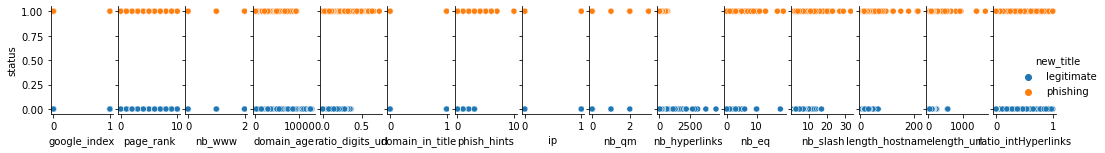

In [53]:
reduced_dataset.insert(reduced_dataset.shape[1], "Status", status_labels)
relacio = sns.pairplot(reduced_dataset, hue = "Status", y_vars = ["status"], x_vars = list(reduced_dataset.columns[:-2]))
relacio.fig.set_size_inches(15,2)
relacio._legend.set_title("new_title")
reduced_dataset.drop(columns = "Status")
reduced_dataset = reduced_dataset.drop(columns = "Status")

Correlació entre les variables independents i la dependent

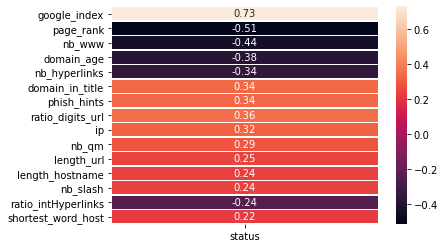

In [14]:
correlacio = reduced_dataset.corr()

plt.figure()
ax = sns.heatmap(pd.DataFrame(correlacio["status"][:-1]), annot=True, linewidths=.5)

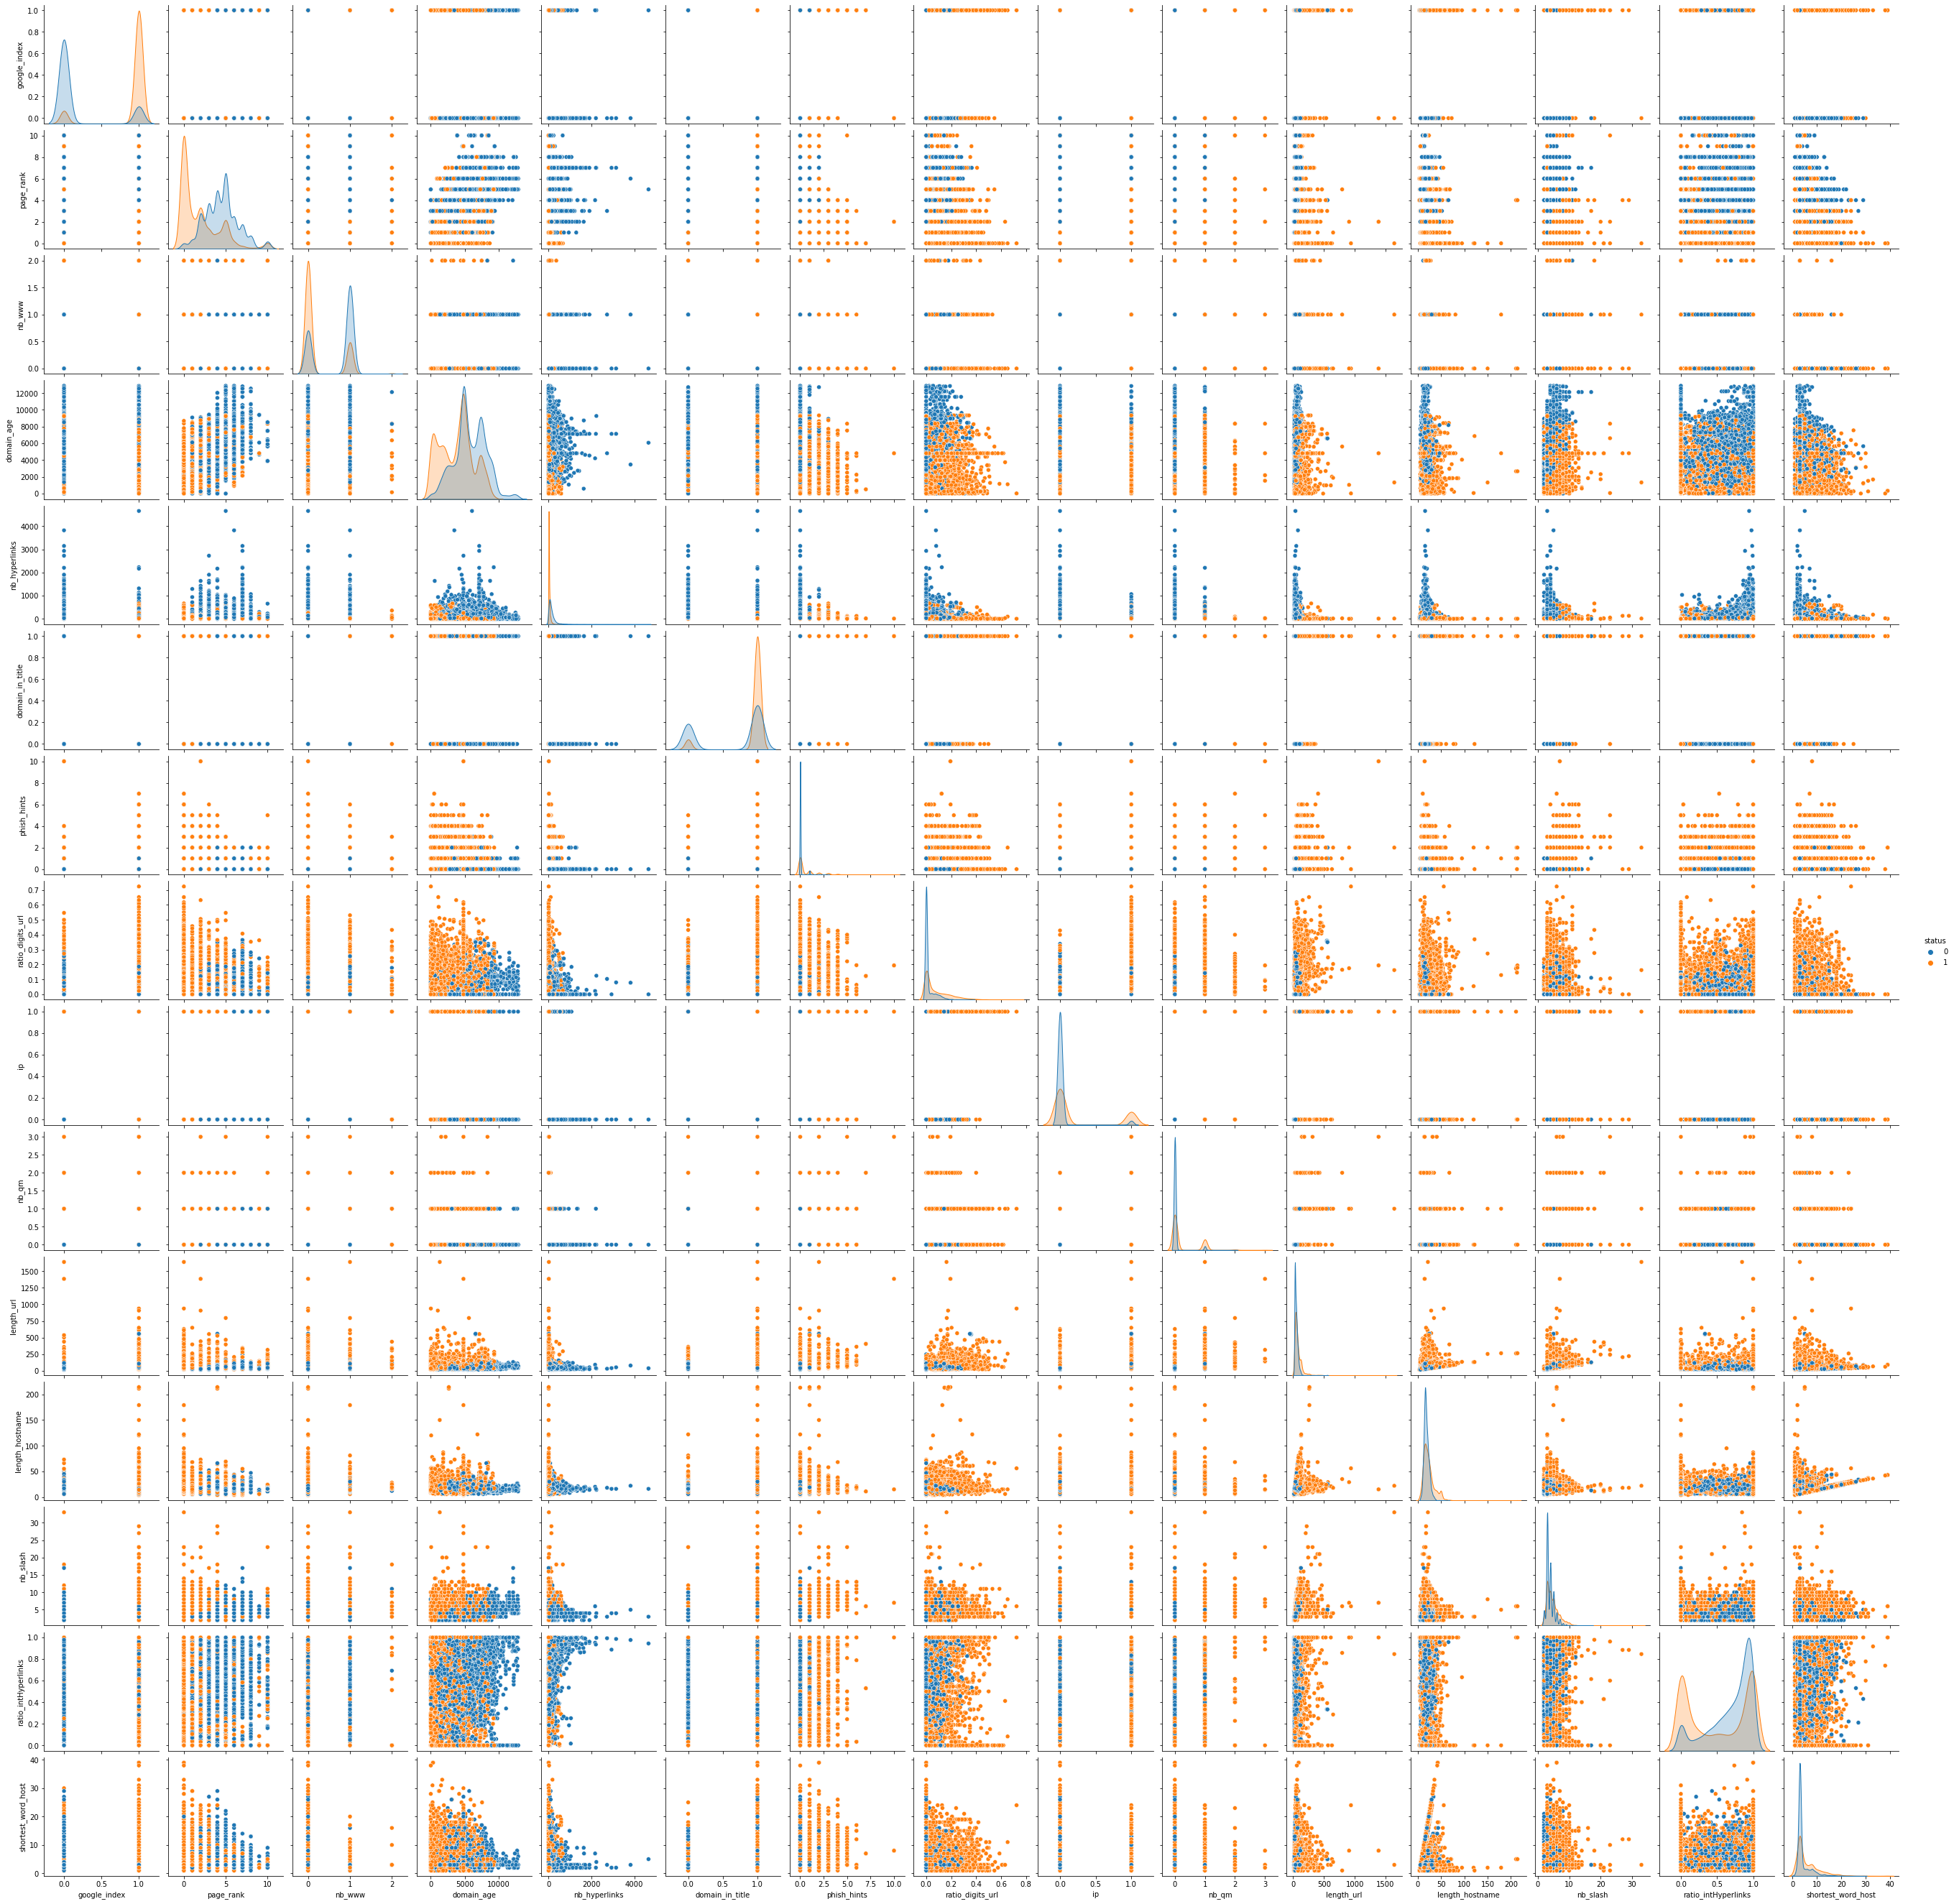

In [15]:
relacio = sns.pairplot(reduced_dataset, hue = "status")

Utilities

In [16]:
def visualize_confusion_matrix(y_pred, y_real):
    # mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

PCA Analysis

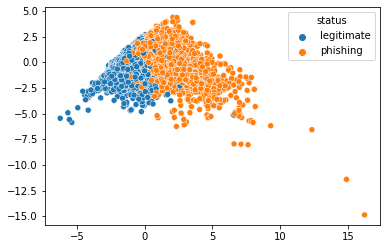

In [17]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=2)[2]
pca = torch.matmul(X_torch, V[:, :2])

sns.scatterplot(x = pca[:, 0], y = pca[:, 1], hue = status_labels);

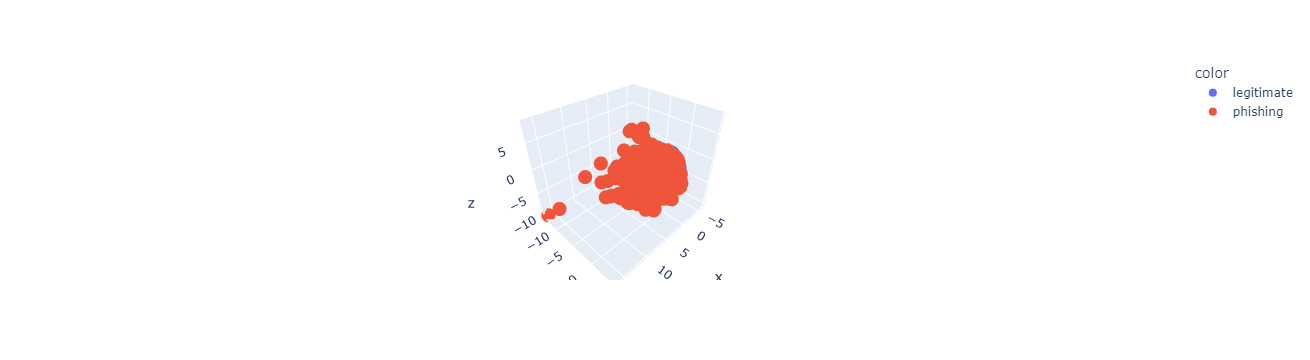

In [18]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

X_torch = torch.tensor(scaled_X)
Y_torch = torch.tensor(Y)
 
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=3)[2]
pca = torch.matmul(X_torch, V[:, :3])

df = px.data.iris()
fig = px.scatter_3d(x = pca[:, 0], y = pca[:, 1], z = pca[:, 2], color = status_labels)
fig.show()

#### Logistic regression

In [19]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=42)

X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

X_torch, Y_torch = torch.Tensor(scaled), torch.Tensor(Y)

data_torch = torch.cat((X_torch, Y_torch), 1)

tensor([[ 0.9343, -0.4674, -0.8936,  ..., -0.6852, -1.6003, -0.7662],
        [ 0.9343,  0.7152,  1.0989,  ...,  0.3774,  0.7793, -0.5124],
        [ 0.9343,  0.3210, -0.8936,  ..., -0.1539, -0.3929, -0.2587],
        ...,
        [ 0.9343, -0.4674, -0.8936,  ..., -0.6852, -1.6003, -0.2587],
        [ 0.9343, -0.4674, -0.8936,  ..., -0.6852, -1.6003, -0.5124],
        [ 0.9343,  0.7152, -0.8936,  ...,  1.4400, -1.6003, -0.7662]])

In [20]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [21]:
epochs = 2000
input_dim = X.shape[1] # Independent variables 
output_dim = 1 # Single binary output 
learning_rate = 0.01

In [22]:
model = LogisticRegression(input_dim,output_dim) #Creem el model

criterion = torch.nn.BCELoss() # Definim el criteri de la funció de cost

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Definim el mètode per reduir el cost

In [23]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter += 1
    if iter % (epochs/5) == 0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = model(X_test)
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(outputs.round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  32%|███▏      | 638/2000 [00:01<00:01, 847.90it/s]

Iteration: 400. 
Test - Loss: 0.29763954877853394. Accuracy: 90.62773403324584
Train -  Loss: 0.28888455033302307. Accuracy: 91.51356080489938



Training Epochs:  42%|████▏     | 849/2000 [00:01<00:01, 906.61it/s]

Iteration: 800. 
Test - Loss: 0.2475925087928772. Accuracy: 91.83070866141732
Train -  Loss: 0.23615112900733948. Accuracy: 92.82589676290463



Training Epochs:  70%|███████   | 1405/2000 [00:02<00:00, 1028.77it/s]

Iteration: 1200. 
Test - Loss: 0.23078885674476624. Accuracy: 92.01662292213473
Train -  Loss: 0.2178952991962433. Accuracy: 92.78215223097114



Training Epochs:  90%|█████████ | 1807/2000 [00:02<00:00, 1245.08it/s]

Iteration: 1600. 
Test - Loss: 0.2227347493171692. Accuracy: 92.09317585301837
Train -  Loss: 0.2089746594429016. Accuracy: 93.00087489063867



Training Epochs: 100%|██████████| 2000/2000 [00:02<00:00, 739.49it/s] 

Iteration: 2000. 
Test - Loss: 0.21805918216705322. Accuracy: 92.15879265091864
Train -  Loss: 0.2037632316350937. Accuracy: 93.04461942257218



### SVM

In [24]:
# define standard scaler
scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = \
    train_test_split(scaled, Y, test_size=0.80, random_state=1)

C = 0.05
models = (svm.SVC(),
         svm.LinearSVC(C=C),
         svm.SVC(kernel = 'rbf', gamma = 0.7, C=C),
         svm.SVC(kernel = 'poly', degree = 2, C=C),
         svm.SVC(kernel = 'poly', degree = 3, C=C))

models = (model.fit(X_train,y_train.flatten()) for model in models)

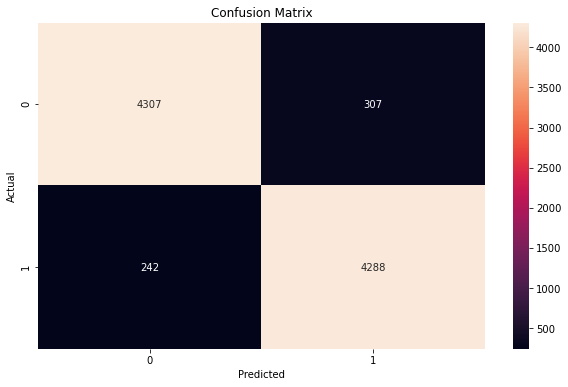

Accuracy "Without kernel": 0.9399606299212598 




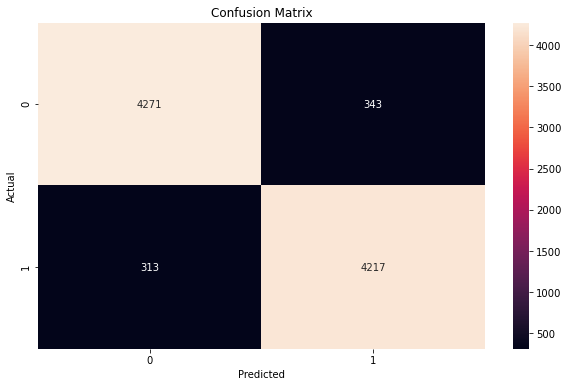

Accuracy "Linear kernel": 0.9282589676290464 




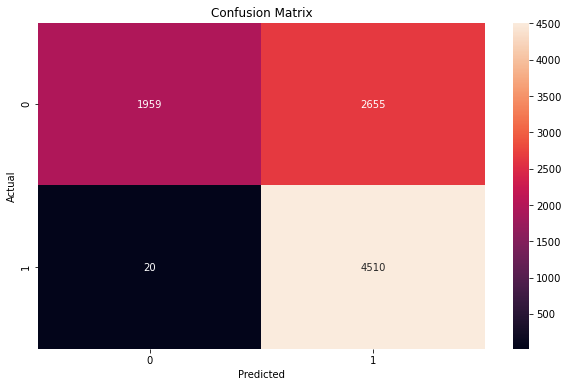

Accuracy "RBF kernel": 0.7074584426946632 




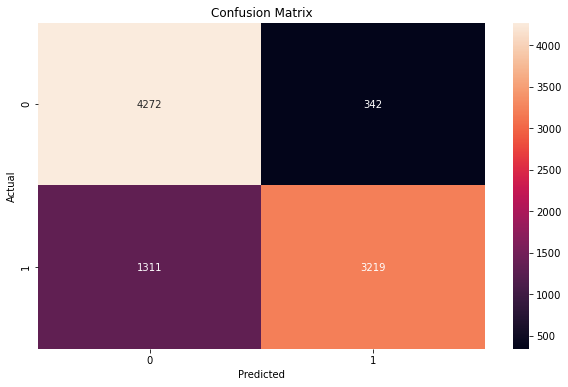

Accuracy "2nd degree Polynomial kernel": 0.8192257217847769 




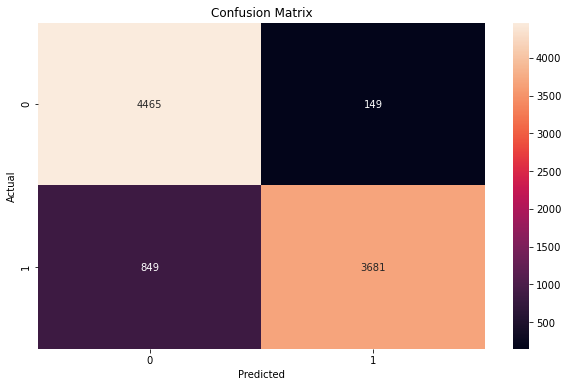

Accuracy "3nd degree Polynomial kernel": 0.8908573928258967 




In [25]:
kernel_names = ["Without kernel", "Linear kernel", "RBF kernel",\
                "2nd degree Polynomial kernel", "3nd degree Polynomial kernel"]

for i, model in enumerate(models):
    predict = model.predict(X_test)
    visualize_confusion_matrix(predict, y_test.flatten())
    print("Accuracy \"" + kernel_names[i] + str("\":"), sum(predict == y_test.flatten())/predict.size, "\n\n")
    